In [ ]:
%matplotlib inline

import collections
import random
import matplotlib.pyplot as plt
import nltk
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mount Data Folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/DL for NLP/text_compression-20231023/'

# Text compression

## 1) Data processing

1.1) Load the train set and dev set text files into a list of sentences where each sentence is tokenised (by splitting by space).

In [ ]:
train_file = open(f'{data_path}train.txt')
dev_file = open(f'{data_path}dev.txt')
train_txt = train_file.read()
dev_txt = dev_file.read()
train_set = [[token for token in sentence.split()] for sentence in train_txt.split('\n')]
dev_set = [[token for token in sentence.split()] for sentence in dev_txt.split('\n')]

In [ ]:
print(f'Size of training dataset:{len(train_set)}')
print(f'Size of dev dataset:{len(dev_set)}')

Size of training dataset:10268
Size of dev dataset:1712


1.2) Extract a vocabulary consisting of the tokens that occur at least 3 times in the train set and output the size of the vocabulary.
Also output the most frequent vocabulary token in the train set.
Include the edge token, unknown token, and pad token in the vocabulary.

In [ ]:
min_freq = 3
frequencies = collections.Counter(token for sen in train_set for token in sen)
vocabulary = sorted(frequencies.keys(), key=frequencies.get, reverse=True)
while frequencies[vocabulary[-1]] < min_freq:
    vocabulary.pop()
print(f'Vocabulary size before adding PAD, UNK, EDGE:{len(vocabulary)}')
print(f'Most frequent vocabulary:{vocabulary[0]}')

vocab = ['<PAD>', '<UNK>', '<EDGE>'] + vocabulary
token2index = {token: i for (i, token) in enumerate(vocab)}
pad_index = token2index['<PAD>']
unk_index = token2index['<UNK>']
edge_index = token2index['<EDGE>']
print(f'Vocabulary size after adding PAD, UNK, EDGE:{len(vocab)}')
print(f'Most frequent vocabulary:{vocab[0]}')

Vocabulary size before adding PAD, UNK, EDGE:7871
Most frequent vocabulary:the
Vocabulary size after adding PAD, UNK, EDGE:7874
Most frequent vocabulary:<PAD>


1.3) Process the loaded token sequences for the train set and dev set using the vocabulary created above in a way that is suitable for a language model, making use of edge tokens, unknown tokens, and pad tokens.

In [ ]:
max_len = max(max(len(text) for text in train_set), max(len(text) for text in dev_set)) + 1
train_indexed = np.full((len(train_set), max_len), pad_index, np.int64)
for i in range(len(train_set)):
  train_indexed[i, 0] = edge_index
  for j in range(len(train_set[i])):
      train_indexed[i, j+1] = token2index.get(train_set[i][j], unk_index)
  train_indexed[i, len(train_set[i])] = edge_index
train_indexed = torch.tensor(train_indexed, device=device)
print('train_x_indexed:')
print(train_indexed)


train_y_indexed = np.full((len(train_set), max_len), pad_index, np.int64)
for i in range(len(train_set)):
    for j in range(len(train_set[i])):
        train_y_indexed[i, j] = token2index.get(train_set[i][j], unk_index)
    train_y_indexed[i, len(train_set[i])] = edge_index
train_y_indexed = torch.tensor(train_y_indexed, device=device)
print('train_y_indexed:')
print(train_y_indexed)

dev_indexed = np.full((len(dev_set), max_len), pad_index, np.int64)
for i in range(len(dev_set)):
  dev_indexed[i, 0] = edge_index
  for j in range(len(dev_set[i])):
    dev_indexed[i, j+1] = token2index.get(dev_set[i][j], unk_index)
  dev_indexed[i, len(dev_set[i])] = edge_index
dev_indexed = torch.tensor(dev_indexed, device=device)
print('dev_x_indexed:')
print(dev_indexed)

dev_y_indexed = np.full((len(dev_set), max_len), pad_index, np.int64)
for i in range(len(dev_set)):
    for j in range(len(dev_set[i])):
        dev_y_indexed[i, j] = token2index.get(dev_set[i][j], unk_index)
    dev_y_indexed[i, len(dev_set[i])] = edge_index
dev_y_indexed = torch.tensor(dev_y_indexed, device=device)
print('dev_y_indexed:')
print(dev_y_indexed)

train_x_indexed:
tensor([[  2, 707,   1,  ...,   0,   0,   0],
        [  2,  25, 165,  ...,   0,   0,   0],
        [  2,   3, 897,  ...,   0,   0,   0],
        ...,
        [  2,  52,  18,  ...,   0,   0,   0],
        [  2, 126,   4,  ...,   0,   0,   0],
        [  2,   1,  42,  ...,   0,   0,   0]], device='cuda:0')
train_y_indexed:
tensor([[ 707,    1, 5921,  ...,    0,    0,    0],
        [  25,  165,   37,  ...,    0,    0,    0],
        [   3,  897,    6,  ...,    0,    0,    0],
        ...,
        [  52,   18,  105,  ...,    0,    0,    0],
        [ 126,    4,    3,  ...,    0,    0,    0],
        [   1,   42,  190,  ...,    0,    0,    0]], device='cuda:0')
dev_x_indexed:
tensor([[   2, 1700, 4131,  ...,    0,    0,    0],
        [   2,   25, 1361,  ...,    0,    0,    0],
        [   2,   96,  977,  ...,    0,    0,    0],
        ...,
        [   2,  155,   37,  ...,    0,    0,    0],
        [   2,  130,   57,  ...,    0,    0,    0],
        [   2,   56, 1191,  

In [ ]:
train_indexed = train_indexed.to(device)
train_y_indexed = train_y_indexed.to(device)
dev_indexed = dev_indexed.to(device)
dev_y_indexed = dev_y_indexed.to(device)

1.4) Finally, load the test set text file as single string and keep it in a variable.

In [ ]:
with open(f'{data_path}test.txt', 'r') as f:
  test_text = f.read()

## 2) Evaluation tools

We're going to need a function that evaluates our language models as well as a way to test this function before we make the language model.
To test the evaluation function, you need to make a mock model which can be used exactly like a language model but that works with some simple rules.
This mock model will then be used to check the evaluation, compression, and decompression functions before we've developed the language model.

A language model function assumes the following signature:

* A parameter `x_indexes` being a tensor that gives the model's input token indexes of a batch of sentences, starting with the edge token.
    The tensor is of type `int64` with shape `(batch size, time steps)`.
* Returns a tensor of logits predicting which vocabulary token can be the next token after each token in `x_indexes`.
    The tensor is of type `float32` with shape `(batch size, time steps, vocab size)`.

2.1) Develop a mock language model.
This language model will be a module that predicts the next token after every token using these rules:

* If the actual previous token (not the predicted one) was 'the' then predict that the current token is 'dog'.
* Otherwise, predict that the current token is 'the'.

Remember that it is logits that will be returned by the forward function, not probabilities.
**Give the token being predicted a logit of 2 and all other tokens a logit of 0.**

In [ ]:
class MockModel(torch.nn.Module):
    def __init__(self, vocab_size, index_of_edge, index_of_the, index_of_dog):
      super().__init__()
      self.vocab_size = vocab_size
      self.ioe = index_of_edge
      self.iot = index_of_the
      self.iod = index_of_dog

    def forward(self, x_indexes):
        logits = torch.zeros((x_indexes.shape[0], x_indexes.shape[1], vocab_size)) # initializing logits matrix
        for i, sample in enumerate(x_indexes):
            for j, token in enumerate(sample):
                if token == self.iot:
                    logits[i, j, self.iod] = 2  # assign a logit of 2 for the index of "dog" if previous token is "the"
                else:
                    logits[i, j, self.iot] = 2  # assign a logit of 2 for the index of "the" if previous token is not "the"
        return logits

In [ ]:
vocab_size = len(vocab) # You can change this to whatever code gives you the vocabulary size.
index_of_edge = token2index['<EDGE>'] # You can change this to whatever code gives you the index of the edge token.
index_of_the = token2index['the'] # You can change this to whatever code gives you the index of the token 'the'.
index_of_dog = token2index['dog'] # You can change this to whatever code gives you the index of the token 'dog'.
mock_model = MockModel(vocab_size, index_of_edge, index_of_the, index_of_dog) # You can change these parameters as you wish.
mock_model = mock_model.to(device)

mock_x_indexes = torch.tensor([
    [index_of_edge, index_of_dog, index_of_the, index_of_the],
    [index_of_edge, index_of_the, index_of_dog, index_of_dog],
], dtype=torch.int64, device=device)

mock_expected_logits = torch.zeros((2, 4, vocab_size), dtype=torch.float32, device=device)
mock_expected_logits[0, 0, index_of_the] = 2
mock_expected_logits[0, 1, index_of_the] = 2
mock_expected_logits[0, 2, index_of_dog] = 2
mock_expected_logits[0, 3, index_of_dog] = 2
mock_expected_logits[1, 0, index_of_the] = 2
mock_expected_logits[1, 1, index_of_dog] = 2
mock_expected_logits[1, 2, index_of_the] = 2
mock_expected_logits[1, 3, index_of_the] = 2
mock_expected_logits = mock_expected_logits.to(device)

mock_logits = mock_model(mock_x_indexes)
mock_logits = mock_logits.to(device)
assert mock_expected_logits[1, 2, index_of_the] == 2
assert mock_expected_logits[1, 3, index_of_the] == 2
assert mock_logits.shape == mock_expected_logits.shape, 'Output shape is invalid.'
assert mock_logits.dtype == mock_expected_logits.dtype, 'Output data type is invalid.'
assert np.unique(mock_logits.detach().cpu().numpy()).tolist() == [0.0, 2.0], 'Output has values other than 0 and 2'
assert (mock_logits == mock_expected_logits).all(), 'Output has the the wrong logits.'
print('Correct!')

Correct!


2.2) Next, we need a function that measures the perplexity of a language model on the dev set.

In [ ]:
def calculate_perplexity(model, data_x, data_y):
  with torch.no_grad():
    pad_mask = data_x == pad_index
    pad_mask = pad_mask.to(device)
    logits = model(data_x)
    logits = logits.to(device)
    train_token_xes = torch.nn.functional.cross_entropy(logits.transpose(1, 2), data_y, reduction='none')
    train_token_xes = train_token_xes.masked_fill(pad_mask, 0.0)
    train_xe_avg = train_token_xes.sum()/(~pad_mask).sum()
    pplx = torch.exp(train_xe_avg).cpu().tolist()
  return pplx

In [ ]:
pplx = calculate_perplexity(mock_model, dev_indexed, dev_y_indexed)
print('Perplexity:', pplx)

Perplexity: 7062.21875


## 3) Compression and decompression
We will now write the code that makes the actual compression and decompression of a text.

The compression algorithm will work as follows:

* You have a string of text to compress called `text` and a language model called `model`.
* Extract a list of tokens from `text` called `tokens` and a list of corresponding token indexes called `indexes`.
* Use `model` on `indexes` to produce `predicted`, a list of predicted next tokens for every index in `indexes`.
    A predicted next token is just the most probable token according to `model`.
* If a token in `predicted` corresponds to a token in `tokens`, then that token can be predicted by the model from its previous tokens.
    In this case, we don't need to have the token written down as it can be predicted, so we replace it in `tokens` with the single letter 'X' to say that a token should be predicted here.
    If 'X' is shorter than the replaced token, then the text will become shorter.
    Since all the text in our data sets is in lowercase, there will never be an 'X' in a sentence, so we can safely use it as a flag.
* If the token isn't correctly predicted then we leave the token in the text as-is.
* After all predictable tokens in `tokens` have been replaced with an 'X', return `tokens` as a space separated string.

The decompression algorithm will work as follows:

* You have a string of compressed text called `text` and a language model called `model`.
* Extract a list of tokens from `text` called `tokens`.
* Go through the tokens in `tokens` from the front and stop at the first 'X'.
* Convert all the tokens before the 'X' to token indexes called `indexes`.
* Use `model` to predict what the most probable token at the end of `indexes` would be.
* Replace the 'X' in `tokens` with this most probable token.
* Repeat this for every 'X'.
* After all 'X' are replaced in `tokens`, return `tokens` as a space separated string.

3.1) Starting with the compression function.
The input text will consist of sentences separated by new lines and space separated tokens (just like the raw data sets).
The function should return a single string with each line in the input text being compressed.
Remember that we want a compressed text to be decompressed back into the exact original text, which means that all out-of-vocabulary tokens must be left as-is (**there must not be any unknown tokens in the output**).

Compressing this sentence using the mock model:

`the dog bit the cat sensually .`

should be compressed into:

`X X bit X cat sensually .`


In [ ]:
def compress_text(text, model):
  compressed_text = []
  sentences = ['<EDGE> ' + sentence for sentence in text.split('\n')]
  sentences_tokens = [sentence.split() for sentence in sentences]
  max_len = max([len(sen) for sen in sentences_tokens])
  tokens_text = [[token2index.get(token, unk_index) for token in tokens]+ [pad_index for i in range(max_len - len(tokens))] for tokens in sentences_tokens]
  indexes = torch.tensor(tokens_text).to(device)
  logits = model(indexes)
  logits = logits.to(device)
  predicted_indexes = logits.argmax(2)
  vocab_keys = list(token2index.keys())
  compressed_text = [['X' if vocab_keys[predicted] == token else token for token, predicted in zip(tokens[1:], pred[0:-1])] for tokens,pred in zip(sentences_tokens, predicted_indexes)]
  compressed_text = [' '.join(tokens) for tokens in compressed_text]
  return '\n'.join(compressed_text)

In [ ]:
decomp_text = "the dog bit the cat sensually ."
compressed = compress_text(decomp_text, mock_model)
print(compressed)

X X bit X cat sensually .


3.2) The decompression function.
Again, The input text will consist of sentences separated by new lines and space separated tokens, only this time, some of those tokens will be an 'X'.
The function should return a single big string where each line in the compressed text is decompressed back into the original input line.

Decompressing the compressed text:

`X X bit X cat sensually .`

which should be decompressed into:

`the dog bit the cat sensually .`


In [ ]:
def decompress_text(text, model):
  decompressed_text = []
  sentences = ['<EDGE> ' + sentence for sentence in text.split('\n')]
  sentences_tokens = [sentence.split() for sentence in sentences]
  for sentence in sentences_tokens:
    for i,j in enumerate(sentence):
      if j=='X':
        tokens_text = [token2index.get(token, unk_index) for token in sentence[:i]]
        indexes = torch.tensor([tokens_text]).to(device)
        logits = model(indexes)
        logits = logits.to(device)
        predicted_index = logits.argmax(2)[0][-1]
        vocab_keys = list(token2index.keys())
        predicted_token = vocab_keys[predicted_index]
        sentence[i] = predicted_token
      else:
        continue
    decompressed_text.append(sentence[1:])
  decompressed_text = [' '.join(tokens) for tokens in decompressed_text]
  return '\n'.join(decompressed_text)

In [ ]:
comp_text = "X X bit X cat sensually ."
decompressed = decompress_text(comp_text, mock_model)
print(decompressed)

the dog bit the cat sensually .


3.3) The space saving amount of the mock model on the test set.
The space saving amount is calculated as follows:

$$\text{space\_saving}(t) = 1 - \frac{|\text{compress}(t)|}{|t|}$$

where $|t|$ is the number of characters in text $t$.

This measure tells what fraction of the original size has been shaved off after compression (higher is better).

In [ ]:
def calculate_space_saved(text, model):
  comp_text = compress_text(text, model)
  return (1 - (len(comp_text)/len(text)))

In [ ]:
print(calculate_space_saved(test_text, mock_model))

0.023646158986776245


## 4) Making and using a language model

Train a language model and use it to compress the test set.


4.1) Train a neural language model on the train set.

In [ ]:
def early_stopping(val_perp_history, patience=5):
    if len(val_perp_history) < patience:
        return False

    is_early_stopping = True
    for i in range(len(val_perp_history) - patience, len(val_perp_history)):
        if val_perp_history[i] <= val_perp_history[i - 1]:
            is_early_stopping = False
            break

    if is_early_stopping:
        return True
    else:
        return False


Epoch 1: 100%|██████████| 81/81 [00:07<00:00, 10.80it/s, train_error=6.01]


Epoch 1 - Train Error: 6.0144, Dev Perplexity: 166.1280


Epoch 2: 100%|██████████| 81/81 [00:07<00:00, 10.68it/s, train_error=5.21]


Epoch 2 - Train Error: 5.2147, Dev Perplexity: 130.1882


Epoch 3: 100%|██████████| 81/81 [00:07<00:00, 10.48it/s, train_error=4.98]


Epoch 3 - Train Error: 4.9811, Dev Perplexity: 113.3965


Epoch 4: 100%|██████████| 81/81 [00:07<00:00, 10.49it/s, train_error=4.83]


Epoch 4 - Train Error: 4.8330, Dev Perplexity: 104.4559


Epoch 5: 100%|██████████| 81/81 [00:07<00:00, 10.49it/s, train_error=4.72]


Epoch 5 - Train Error: 4.7192, Dev Perplexity: 98.6806


Epoch 6: 100%|██████████| 81/81 [00:07<00:00, 10.71it/s, train_error=4.62]


Epoch 6 - Train Error: 4.6225, Dev Perplexity: 94.9297


Epoch 7: 100%|██████████| 81/81 [00:07<00:00, 10.73it/s, train_error=4.54]


Epoch 7 - Train Error: 4.5381, Dev Perplexity: 91.8608


Epoch 8: 100%|██████████| 81/81 [00:07<00:00, 10.60it/s, train_error=4.47]


Epoch 8 - Train Error: 4.4650, Dev Perplexity: 89.3920


Epoch 9: 100%|██████████| 81/81 [00:07<00:00, 10.79it/s, train_error=4.39]


Epoch 9 - Train Error: 4.3939, Dev Perplexity: 87.5073


Epoch 10: 100%|██████████| 81/81 [00:07<00:00, 10.88it/s, train_error=4.32]


Epoch 10 - Train Error: 4.3246, Dev Perplexity: 86.0602


Epoch 11: 100%|██████████| 81/81 [00:07<00:00, 10.50it/s, train_error=4.27]


Epoch 11 - Train Error: 4.2698, Dev Perplexity: 84.8349


Epoch 12: 100%|██████████| 81/81 [00:07<00:00, 10.84it/s, train_error=4.21]


Epoch 12 - Train Error: 4.2059, Dev Perplexity: 84.0419


Epoch 13: 100%|██████████| 81/81 [00:07<00:00, 10.59it/s, train_error=4.15]


Epoch 13 - Train Error: 4.1473, Dev Perplexity: 83.5081


Epoch 14: 100%|██████████| 81/81 [00:07<00:00, 10.76it/s, train_error=4.1]


Epoch 14 - Train Error: 4.0967, Dev Perplexity: 82.9117


Epoch 15: 100%|██████████| 81/81 [00:07<00:00, 10.57it/s, train_error=4.04]


Epoch 15 - Train Error: 4.0381, Dev Perplexity: 82.3130


Epoch 16: 100%|██████████| 81/81 [00:07<00:00, 10.74it/s, train_error=3.99]


Epoch 16 - Train Error: 3.9868, Dev Perplexity: 82.1690


Epoch 17: 100%|██████████| 81/81 [00:08<00:00,  9.95it/s, train_error=3.94]


Epoch 17 - Train Error: 3.9357, Dev Perplexity: 82.0825


Epoch 18: 100%|██████████| 81/81 [00:07<00:00, 10.80it/s, train_error=3.89]


Epoch 18 - Train Error: 3.8876, Dev Perplexity: 81.8805


Epoch 19: 100%|██████████| 81/81 [00:07<00:00, 10.69it/s, train_error=3.84]


Epoch 19 - Train Error: 3.8400, Dev Perplexity: 82.0689


Epoch 20: 100%|██████████| 81/81 [00:07<00:00, 10.82it/s, train_error=3.79]


Epoch 20 - Train Error: 3.7935, Dev Perplexity: 82.0560


Epoch 21: 100%|██████████| 81/81 [00:07<00:00, 10.73it/s, train_error=3.75]


Epoch 21 - Train Error: 3.7513, Dev Perplexity: 82.0526


Epoch 22: 100%|██████████| 81/81 [00:07<00:00, 10.75it/s, train_error=3.7]


Epoch 22 - Train Error: 3.6999, Dev Perplexity: 82.6520


Epoch 23: 100%|██████████| 81/81 [00:07<00:00, 10.68it/s, train_error=3.66]


Epoch 23 - Train Error: 3.6592, Dev Perplexity: 82.3141


Epoch 24: 100%|██████████| 81/81 [00:07<00:00, 10.70it/s, train_error=3.62]


Epoch 24 - Train Error: 3.6197, Dev Perplexity: 83.0358


Epoch 25: 100%|██████████| 81/81 [00:07<00:00, 10.70it/s, train_error=3.58]


Epoch 25 - Train Error: 3.5752, Dev Perplexity: 83.5540


Epoch 26: 100%|██████████| 81/81 [00:07<00:00, 10.65it/s, train_error=3.54]


Epoch 26 - Train Error: 3.5364, Dev Perplexity: 84.0300
Early stopping at epoch: 26


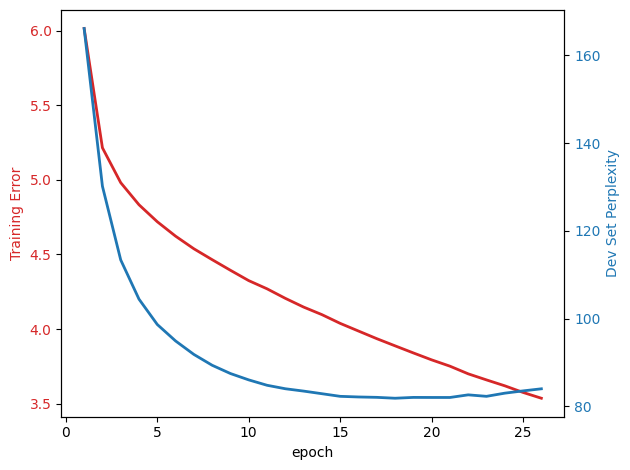

In [ ]:
class Model(torch.nn.Module):

    def __init__(self, vocab_size, embedding_size, state_size, dropout_rate=0.5):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        self.rnn_cell = torch.nn.LSTMCell(embedding_size, state_size)
        self.output_layer = torch.nn.Linear(state_size, vocab_size)
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, text_x_indexed):
        batch_size = text_x_indexed.shape[0]
        time_steps = text_x_indexed.shape[1]

        embedded = self.embedding(text_x_indexed)
        state = torch.zeros((batch_size, self.rnn_cell.hidden_size), device=text_x_indexed.device)
        c = torch.zeros((batch_size, self.rnn_cell.hidden_size), device=text_x_indexed.device)
        interm_states_list = []
        for t in range(time_steps):
            (state, c) = self.rnn_cell(embedded[:, t, :], (state, c))
            state = self.dropout(state)
            interm_states_list.append(state)
        interm_states = torch.stack(interm_states_list, dim=1)
        return self.output_layer(interm_states)

model = Model(len(vocab), embedding_size=400, state_size=400, dropout_rate=0.5)
model.to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 128

train_errors = []
dev_per = []

for epoch in range(1, 150):
    total_loss = 0
    total_batches = 0
    model.train()
    row_indexes = np.arange(len(train_indexed)) # training indicies
    np.random.shuffle(row_indexes) # shuffle indicies

    progress_bar = tqdm(range(0, len(train_indexed), batch_size), desc=f"Epoch {epoch}")

    for i in progress_bar:
        batch_row_indexes = row_indexes[i:i+batch_size] # take a set of indicies of size batch_size
        batch_x_indexed = train_indexed[batch_row_indexes] # extract rows from x
        batch_y_indexed = train_y_indexed[batch_row_indexes] # extract rows from y

        pad_mask = batch_x_indexed == pad_index

        optimiser.zero_grad()
        logits = model(batch_x_indexed)
        batch_token_errors = torch.nn.functional.cross_entropy(logits.transpose(1, 2), batch_y_indexed, reduction='none')
        batch_token_errors = batch_token_errors.masked_fill(pad_mask, 0.0)
        batch_error = batch_token_errors.sum()/(~pad_mask).sum()
        total_loss += batch_error.item()
        total_batches += 1
        batch_error.backward()
        optimiser.step()
        progress_bar.set_postfix({'train_error': total_loss / total_batches})


    average_loss = total_loss / total_batches
    train_errors.append(average_loss)

    model.eval()
    # Calculate perplexity on dev set
    dev_perplexity = calculate_perplexity(model, dev_indexed, dev_y_indexed)
    dev_per.append(dev_perplexity)
    print(f"Epoch {epoch} - Train Error: {average_loss:.4f}, Dev Perplexity: {dev_perplexity:.4f}")
    if early_stopping(dev_per, 3):
      print("Early stopping at epoch: {}".format(epoch))
      break

# Plotting
fig, ax1 = plt.subplots()

# Plot training errors
ax1.set_xlabel('epoch')
ax1.set_ylabel('Training Error', color='tab:red')
ax1.plot(range(1, len(train_errors) + 1), train_errors, color='tab:red', linestyle='-', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:red')

# Instantiate a second axes that shares the same x-axis and plot dev perplexity
ax2 = ax1.twinx()
ax2.set_ylabel('Dev Set Perplexity', color='tab:blue')
ax2.plot(range(1, len(dev_per) + 1), dev_per, color='tab:blue', linestyle='-', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()

In [ ]:
print("Model saving on the DEV set: {}".format(calculate_space_saved(dev_txt, model)))

Model saving on the DEV set: 0.037715084207065375


4.2) Measure the space saving amount of the trained model on the test text.

In [ ]:
print(f"Space saving amount on the test set = {calculate_space_saved(test_text, model)}")
compressed_test_text = compress_text(test_text, model)
decompressed_test_text = decompress_text(test_text, model)
assert test_text == decompressed_test_text

Space saving amount on the test set = 0.03994122789752419


4.3) Analyse the model's output.

In [ ]:
sentences = test_text.split('\n')[:-1]
compressed_sentences = [compress_text(sentence, model) for sentence in sentences]
space_savings = [calculate_space_saved(sentence, model) for sentence in sentences]

most_compressed = sorted(zip(sentences, compressed_sentences, space_savings), key=lambda x: x[2], reverse=True)[:5]
least_compressed = sorted(zip(sentences, compressed_sentences, space_savings), key=lambda x: x[2])[:5]

print("Most Compressed Sentences:")
for sentence, compressed, saving in most_compressed:
    print(f"Original sentence: {sentence}, Compressed sentence: {compressed}, Space Saving: {saving}")
print()
print("Least Compressed Sentences:")
for sentence, compressed, saving in least_compressed:
    print(f"Original sentence: {sentence}, Compressed sentence: {compressed}, Space Saving: {saving}")


Most Compressed Sentences:
Original sentence: 1 7 . 0 % of all households were made up of individuals , and 3 . 8 % had someone living alone who was 6 5 years of age or older ., Compressed sentence: 1 7 . 0 X X all X X X X X X X X 3 X 8 X had X X X X X 6 X X X X or X X, Space Saving: 0.46153846153846156
Original sentence: 3 4 . 6 % of all households were made up of individuals , and 1 5 . 7 % had someone living alone who was 6 5 years of age or older ., Compressed sentence: 3 4 . 6 X X all X X X X X X X X X 5 X 7 X had X X X X X 6 X X X X or X X, Space Saving: 0.4545454545454546
Original sentence: 1 4 . 0 % of all households were made up of individuals , and 4 . 5 % had someone living alone who was 6 5 years of age or older ., Compressed sentence: 1 4 . 0 X X all X X X X X X X X 4 X X X had X X X X X 6 X X of X or X X, Space Saving: 0.4538461538461539
Original sentence: hispanic or latino of any race were 3 . 0 0 % of the population ., Compressed sentence: hispanic X X X any X X 3 X 0 

4.4) Is the reason for whether a sentence is compressible or not due to its similarity to the train set (a sentence that is similar to one in the train set would be easier to predict and thus more tokens will be compressed)?

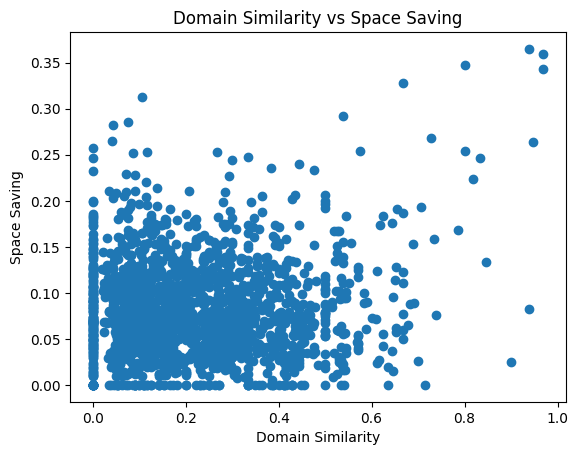

In [ ]:
train_trigrams = set()
for sentence in train_txt.split('\n'):
  for tri in nltk.trigrams(sentence.split()):
    train_trigrams.add(tri)

domain_similarity = []
space_saving = []

for sentence in test_text.split('\n'):
  processed_sentence = '<EDGE>' + ' ' + ' '.join([token if token in vocab else '<UNK>' for token in sentence.split()])
  test_tri = list(nltk.trigrams(processed_sentence.split()))
  common_tri = sum(1 for tri in test_tri if tri in train_trigrams)
  domain_sim = common_tri / len(test_tri) if test_tri else 0
  saving = calculate_space_saved(processed_sentence, model)

  domain_similarity.append(domain_sim)
  space_saving.append(saving)

plt.scatter(domain_similarity, space_saving)
plt.xlabel('Domain Similarity')
plt.ylabel('Space Saving')
plt.title('Domain Similarity vs Space Saving')
plt.show()


Domain similarity alone isn't enough to explain how well text can be compressed because of a few reasons. First, even if a sentence looks similar to what the model learned from the training set, it might not predict the next words correctly. Second, sentences can have similar trigrams but be different in overall meaning or structure, which affects how predictable they are and so how compressable. Also, the language model might be better at understanding some aspects of language than others. In addition, if there are words the model hasn't seen before (unknown tokens), it can't compress them well, no matter how similar the sentence is to the training set.

## 5) Conclusions

The current text compression algorithm only replaces a word with 'X' when it exactly matches the predicted token. To enhance compression, we can relax this criterion by replacing words with 'X' in two additional scenarios: when the predicted token has a high probability (above a set threshold), or when the predicted token is semantically similar to the word. Semantic similarity can be determined using word embeddings, language models, or other measures that assess the meaning and context of words.